# 관광객 추정 버스 이용자 추출 알고리즘
* input: 버스 이용 데이터
* ouput: [user_id, first_usage_date, last_usage_date, tourist_flag]

In [3]:
import os
import datetime
import pandas as pd
from tqdm import tqdm
from pyarrow import csv

# 사용자 정의
import bus

In [4]:
# 관광객 연속 체류 기간 (default: 15)
day = 15

geton_station_name = "geton_stataion_name"

# 1. Def

#### 1) 데이터 전처리
* 날짜 데이터 int -> datetime 변환

In [5]:
def data_preprocessing(usage_df):
    # datetime64로 형 변환 # M[base_date] = pd.to_datetime(M[base_date], format='%Y%m%d')
    datetime_cols = ["geton_datetime", "getoff_datetime"]    
    for col in tqdm(datetime_cols):
        usage_df[col] = pd.to_datetime(usage_df[col], format='%Y%m%d%H%M%S')
    return usage_df

#### 2) 전체 유저 이용데이터 분석
* 전체 사용자 리스트 추출
* 사용기간 분석

In [176]:
def create_user_df(usage_df):    # 유저 목록 생성
    return usage_df[["user_id"]].drop_duplicates()

def analyze_usage_date(usage_df, user_df):    # 이용기간 및 이용 날짜 분석
    grouped = usage_df[["user_id", "base_date"]].drop_duplicates().groupby(by=["user_id"], as_index=False)
    first_date_df = grouped.min().rename(columns = {"base_date" : "first_date"})
    last_date_df = grouped.max().rename(columns = {"base_date" : "last_date"})
    use_days_df= grouped.count().rename(columns = {"base_date" : "use_days"})
    user_df = pd.merge(user_df, first_date_df, on="user_id")
    user_df = pd.merge(user_df, last_date_df, on="user_id")
    user_df = pd.merge(user_df, use_days_df, on="user_id")
    user_df["period"] = user_df["last_date"] - user_df["first_date"]
    user_df["period"] = user_df["period"].apply(lambda x : int(x) + 1)
    return user_df

def analyze_usage_num(usage_df, user_df):    # 버스 이용량 분석
    grouped = usage_df[["user_id", "base_date"]].groupby(by=["user_id"], as_index=False)
    count_df = grouped.count().rename(columns = {"base_date" : "usage"})
    user_df = pd.merge(user_df, count_df, on="user_id")
    return user_df

def analyze_start_end(usage_df, user_df):    # 첫 승차 정류장과 마지막 하차 정류장 분석
    grouped = usage_df.groupby(by=["user_id"], as_index=False)
    first = grouped.first()
    last = grouped.last()
    first['first_station'] = first['geton_stataion_name'].apply(lambda x : "airport" if str(x).find("공항") != -1 else "harbor" if (
                                                             bool(str(x).find("여객터미널") != -1)| 
                                                             bool(str(x).find("여객선")     != -1)|
                                                             bool(str(x).find("제6부두")    != -1)|
                                                             bool(str(x).find("제4부두")    != -1)|
                                                             bool(str(x).find("임항로")     != -1)|
                                                             bool(str(x).find("제주해양경찰서") != -1)) else "other")
    last['last_station'] = last['getoff_station_name'].apply(lambda x : "airport" if str(x).find("공항") != -1 else "harbor" if (
                                                             bool(str(x).find("여객터미널") != -1)| 
                                                             bool(str(x).find("여객선")     != -1)|
                                                             bool(str(x).find("제6부두")    != -1)|
                                                             bool(str(x).find("제4부두")    != -1)|
                                                             bool(str(x).find("임항로")     != -1)|
                                                             bool(str(x).find("제주해양경찰서")!= -1))  else "other")
    first2 = first[["user_id", "first_station"]]
    last2 = last[["user_id", "last_station"]]
    flag_df = pd.merge(first2, last2, on = "user_id")
    flag_df["both"] = (flag_df["first_station"]!='other') & (flag_df["last_station"]!='other')
    flag_df["first"] = (flag_df["first_station"]!='other') & (flag_df["last_station"]=='other')
    flag_df["last"] = (flag_df["first_station"]=='other') & (flag_df["last_station"]!='other')
    flag_df["neither"] = (flag_df["first_station"]=='other') & (flag_df["last_station"]=='other')
    flag_df = flag_df.reset_index()
    flag_df = flag_df[['user_id', 'first_station', 'last_station', 'both', 'first', 'last', 'neither']]
    user_df = pd.merge(user_df, flag_df)
    return user_df

#### 3) 추출1 - 방문 기간
* 2~14일 사이 방문

In [207]:
def extract_user1(user_df):
    user_df["tourist"] = (2 <= user_df['period']) & (user_df['period'] <= 14)
    return user_df

In [ ]:
#### 4) 추출2 - 이용 기간 고려
* 70%이상 이용

In [83]:
def extract_user2(user_df):
    select = user_df.columns
    user_df["goal"] = user_df["period"].apply(lambda x : int(x*7/10))
    user_df["tourist"] = user_df["tourist"] & (user_df["use_days"] >= user_df["goal"])
    return user_df[select]

#### 5) 추출3 - 방문 정류장 고려
관광객으로 유추 가능한 사용자 3차 추출.
1. 승/하차 정류장 중 '제주국제공항'이 존재하는가?
2. 승/하차 정류장 중 '제주연안여객터미널', '국제여객선터미널'등이 존재하는가?
3. 승/하차 정류장 중 '호텔/여관/펜션' 등이 존재하는가?

In [198]:
def extract_user3(user_df):
    user_df["tourist"] = user_df["tourist"] & user_df["both"]
#     user_df["tourist"] = user_df["tourist"] & (user_df["both"] | user_df["first"] | user_df["last"])
    return user_df

### 2. main

In [202]:
# start_date = datetime.datetime(2019, 6, 1)
# end_date = datetime.datetime(2019, 8, 29)

# input_path_list = bus.make_input_path(start_date, end_date)

# usage_df = bus.load_total_usage_data(input_path_list)
# usage_df = data_preprocessing(usage_df)


user_df = create_user_df(usage_df)
print("유저 목록 생성")
user_df = analyze_usage_date(usage_df, user_df)
print("이용 날짜 분석 완료")
user_df = analyze_usage_num(usage_df, user_df)
print("이용 횟수 분석 완료")
user_df = analyze_start_end(usage_df, user_df)
print("출발, 도작지 분석 완료", '\n')

D = usage_df["user_id"]
print('추출 전 data의 개수', len(D))
print('추출 전 user_id의 개수', len(user_df), '\n')

user_df = extract_user1(user_df)
print('1차 추출 (방문기간 고려) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

user_df = extract_user2(user_df)
print('2차 추출 (이용 날짜 수 고려) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

user_df = extract_user3(user_df)
print('3차 추출 (시작, 끝 정류장 고려) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

#유의사항: 실제 사용자(관광객) 수는 user_id의 개수보다 크거나 같을 것. (사용자 수는 user_count로 파악할 것.)
user_df.to_csv("user_list.csv", encoding="utf-8", index=False)
print("저장완료")

유저 목록 생성
이용 날짜 분석 완료
이용 횟수 분석 완료
출발, 도작지 분석 완료 

추출 전 data의 개수 12291789
추출 전 user_id의 개수 726322 

1차 추출 (방문기간 고려) 완료 
user_id의 개수: 415965 


2차 추출 (이용 날짜 수 고려) 완료 
user_id의 개수: 387314 


3차 추출 (시작, 끝 정류장 고려) 완료 
user_id의 개수: 22951 


저장완료


In [205]:
# 공항에서 출발
a = user_df[user_df["first_station"] == "airport"]
b = a["last_station"].value_counts()
b

other      116921
airport     32337
harbor        436
Name: last_station, dtype: int64

In [206]:
# 항만에서 출발
a = user_df[user_df["first_station"] == "harbor"]
b = a["last_station"].value_counts()
b

other      2873
airport     651
harbor      404
Name: last_station, dtype: int64

### 3. 결과 출력 

In [139]:
import pandas as pd
import numpy as np
import datetime
import bus
from matplotlib import pyplot as plt

In [140]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

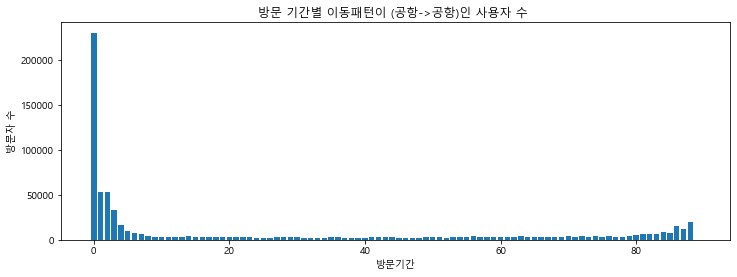

In [141]:
user_df = bus.create_user_df()
register_df = user_df[user_df["tourist"] == 0]
tourist_df = user_df[user_df["tourist"] == 1]
data = user_df.groupby("use_days").count()["user_id"]
data2 = list(data)
plt.rcParams["figure.figsize"] = (12,4)
plt.bar(range(len(data2)), data2)
plt.xlabel('방문기간')
plt.ylabel('방문자 수')
plt.title('방문 기간별 이동패턴이 (공항->공항)인 사용자 수 ')
plt.show()

In [146]:
user_df

,user_id,first_date,last_date,use_days,period,usage,first_station,last_station,both,first,last,neither,tourist
0,f6f372cf8c6732eafc2a82b4f9d7a08bb3b493213ea4ef...,20190601,20190609,5,9,14,other,other,False,False,False,True,False
1,3f6cfe2429f6e8d62cddc39222993405789b7b9ea2a592...,20190601,20190828,26,228,59,other,other,False,False,False,True,False
2,107cd874732b48a35df957bf653751154b0234e5573ba5...,20190601,20190828,63,228,249,other,other,False,False,False,True,False
3,27b16001fafd812b1e5c474cbc60455a9286ad27ecf8e5...,20190601,20190828,47,228,83,other,other,False,False,False,True,False
4,89c9a1c6e5915df4c192acc54067ee9a743f44eb559f3b...,20190601,20190828,26,228,35,other,other,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726317,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,20190828,20190828,1,1,1,other,other,False,False,False,True,False
726318,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,20190828,20190828,1,1,1,other,other,False,False,False,True,False
726319,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,20190829,20190829,1,1,1,other,other,False,False,False,True,False
726320,670048e0bb0ed87661ef4e33fe476d74e4616c137bcdb0...,20190829,20190829,1,1,1,other,other,False,False,False,True,False


<ipython-input-208-3a63d419055f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[user_df['last_station'] == "airport"]


3      6240
4      5969
2      3916
5      2697
1      2366
       ... 
174       2
31        2
172       2
175       2
131       1
Name: period, Length: 149, dtype: int64


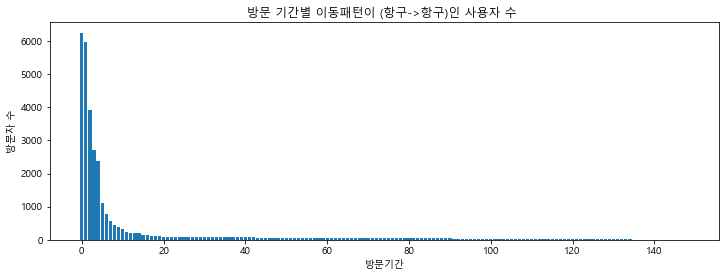

In [208]:
data = user_df[user_df['first_station'] == "airport"]
data = data[user_df['last_station'] == "airport"]
data = data["period"].value_counts()
data2 = data
print(data)
plt.rcParams["figure.figsize"] = (12,4)
plt.bar(range(len(data2)), data2)
plt.xlabel('방문기간')
plt.ylabel('방문자 수')
plt.title('방문 기간별 이동패턴이 (항구->항구)인 사용자 수 ')
plt.show()

'ed5ade7e201a2a20ba05d0a6a1e32b1036c08de636ae2e0f0eb214136ec4d4c8'

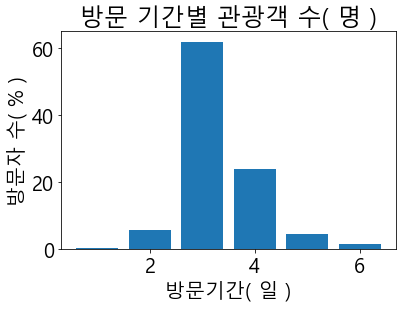

In [378]:
data2 = [0.3, 5.7, 61.8, 23.8, 4.5, 1.3]
plt.rcParams["figure.figsize"] = (6,4)
plt.bar(range(1, 7), data2)
plt.xlabel('방문기간( 일 )')
plt.ylabel('방문자 수( % )')
plt.title('방문 기간별 관광객 수( 명 )')
plt.show()

In [155]:

i=22
tourist = list(user_infor_df[user_infor_df["tourist"] == 1]["user_id"])
d = usage_df.query('{} == "{}"'.format("user_id", tourist[i]))[selete].sort_values(by = "geton_datetime")
end = d.tail(n=1).iloc[0, 4]
print(type(end))

<class 'float'>


In [32]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

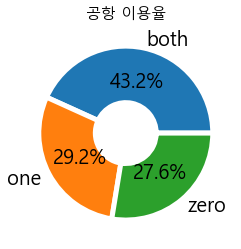

In [170]:
# usage_df.count()
from matplotlib import pyplot as plt
data = [38343, 25887, 24457]
categories = ['both', 'one', 'zero']
wedgeprops={'width': 0.65, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(data, labels=categories, autopct="%0.1f%%", wedgeprops=wedgeprops)
plt.rc('font', size=20)
plt.title('공항 이용율', fontsize=15)
plt.show()

In [200]:
user_df[user_df["both"]]

,user_id,first_date,last_date,use_days,period,usage,first_station,last_station,both,first,last,neither,tourist
632,9adc57737a186d9ed8fa9954fd315c5f7377dad2a76f18...,20190601,20190828,70,228,206,airport,airport,True,False,False,False,False
633,2a8273f9a216dbfd5f84f4f83aa550a0cc346d6a313288...,20190601,20190824,32,224,126,airport,airport,True,False,False,False,False
636,564e041fed599dd558beca16d979edd97d24854176cdbe...,20190601,20190823,11,223,15,airport,airport,True,False,False,False,False
950,f10c915244b313a7c4e92e4daa144590667c613212eac2...,20190601,20190828,58,228,80,airport,airport,True,False,False,False,False
954,78ddf738c77300ac33d58fbe886f6778eab820a3248219...,20190601,20190628,3,28,5,airport,airport,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725894,6609829bc2cc5c773f6dc0a61fb600ce3ea5a67961aee1...,20190828,20190828,1,1,1,airport,airport,True,False,False,False,False
726048,d124bd794f91868206d1c9d411da7f8f856b19137b950b...,20190828,20190828,1,1,1,airport,harbor,True,False,False,False,False
726049,9e10854ae42cda1d589f11896060170705cf5022cbb945...,20190828,20190828,1,1,1,airport,harbor,True,False,False,False,False
726050,ca183fc81036f23523bee7167499a7991d1bc6aa39002a...,20190828,20190828,1,1,1,harbor,harbor,True,False,False,False,False


# 추출된 임의의 관광객 이동 패턴 출력 예시

In [196]:
def show_od_pattern(user_df, num):
    data = user_df[user_df["tourist"]]
    id = data.iloc[num, 0]
    select = ["base_date", "geton_datetime", "geton_stataion_name", "getoff_datetime", "getoff_station_name", "user_count"]
    od_df = usage_df.query('user_id == "{}"'.format(id)).sort_values('geton_datetime')
    return od_df[select]

In [197]:
show_od_pattern(user_df, 10)

,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
656,20190601,2019-06-01 18:02:04,월평아왜낭목,2019-06-01 18:11:17,중문초등학교,1
218677,20190602,2019-06-02 15:32:38,공무원연금공단,2019-06-02 15:48:18,회수마을회관,1
218674,20190602,2019-06-02 16:18:17,회수동,2019-06-02 16:46:15,1100고지휴게소,1
218676,20190602,2019-06-02 17:53:40,영실입구,2019-06-02 18:24:46,중문사거리,1
218675,20190602,2019-06-02 18:35:28,중문초등학교,2019-06-02 18:44:47,제주월드컵경기장서귀포버스터미널,1
408989,20190603,2019-06-03 09:38:47,국세공무원교육원공무원연금공단,2019-06-03 10:29:51,제주국제공항(종점),1
